## Лабораторная работа №8. 
Рекуррентные нейронные сети для анализа временных рядов
#### Данные: 
Набор данных для прогнозирования временных рядов, который состоит из среднемесячного числа пятен на солнце, наблюдаемых с января 1749 по август 2017. Данные в виде csv-файла можно скачать на сайте Kaggle -> https://www.kaggle.com/robervalt/sunspots/
#### Ход выполнения:

###### Задание 1.
Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).


Загрузим данные из Sunspots.csv файла.

In [1]:
from pandas import read_csv

series = read_csv('./input/Sunspots.csv', header=0, index_col=0, squeeze=True, parse_dates = ['Date'])
print(series.head())

        Date  Monthly Mean Total Sunspot Number
0 1749-01-31                               96.7
1 1749-02-28                              104.3
2 1749-03-31                              116.7
3 1749-04-30                               92.8
4 1749-05-31                              141.7


Изобразим ряд в виде графика.

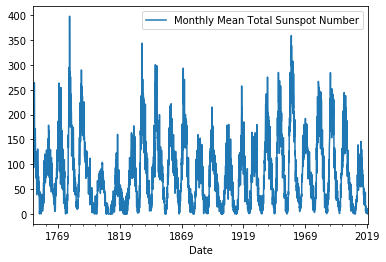

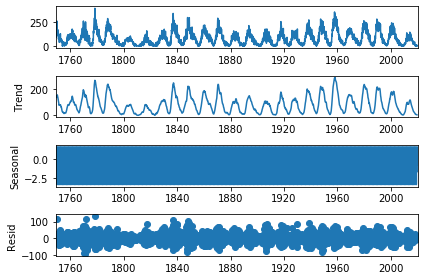

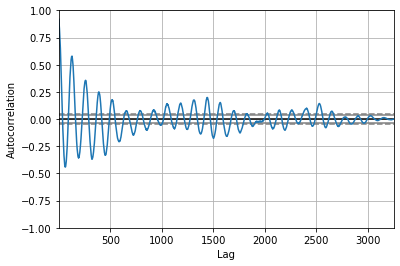

In [2]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose

series.set_index('Date', inplace=True)
series.plot()
plt.show()

seasonal_decompose(series, model='additive').plot()
plt.show()

autocorrelation_plot(series)
plt.show()

###### Задание 2.
Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.


In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(series, test_size=0.2, shuffle=False)
train_data = train['Monthly Mean Total Sunspot Number']
test_data = test['Monthly Mean Total Sunspot Number']

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

###### Задание 3.
Примените модель ARIMA для прогнозирования значений данного временного ряда.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2600
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -12127.880
Method:                       css-mle   S.D. of innovations             25.676
Date:                Tue, 07 Apr 2020   AIC                          24269.760
Time:                        15:47:55   BIC                          24310.803
Sample:                             1   HQIC                         24284.631
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0321      0.241     -0.133      0.894      -0.504       0.440
ar.L1.D.y     -0.4165      0.020    -21.291      0.000      -0.455      -0.378
ar.L2.D.y     -0.2957      0.021    -14.024      0.0

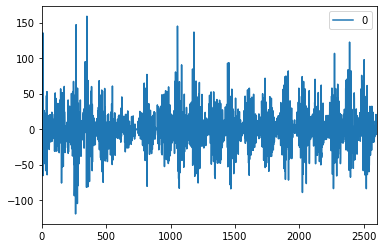

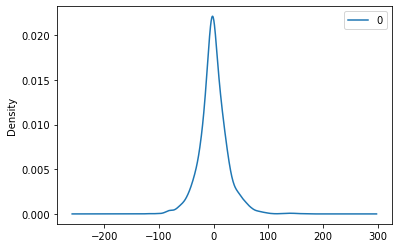

                 0
count  2600.000000
mean      0.005148
std      25.681788
min    -119.425537
25%     -13.034809
50%      -1.089437
75%      12.808497
max     158.896676


In [4]:
from pandas import DataFrame
import numpy as np
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.array(train_data), order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Используем обученую модель для прогнозирования.

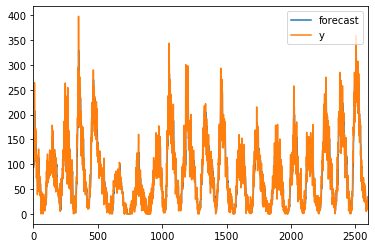

In [5]:
import pandas as pd
model_fit.plot_predict(dynamic=False)
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error

history = [x for x in train_data]

predictions = list()
for t in range(len(test_data)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
error = mean_squared_error(test_data, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 538.131


Отобразим график тестовых данных и прогнозирования.

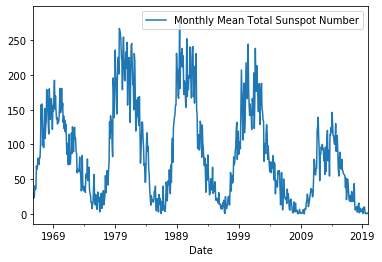

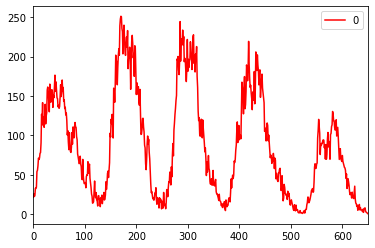

In [7]:
DataFrame(test_data).plot()
DataFrame(predictions).plot(color = "red")
plt.show()

Можно заметить, что графически данные в большей мере совпадают, что говорит об успешном прогнозировании.

###### Задание 4.
Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).


Построим сеть из сверточного слоя, двух рекуррентных и полносвязанных для определения результата.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense
from tensorflow.keras.losses import Huber

tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

model = Sequential([
    Conv1D(64, 5, strides=1, padding="same", activation="relu", input_shape=[None, 1]),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1),
])

model.compile(loss=Huber(), optimizer='adam', metrics=["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, None, 32)          4128      
_________________________________________________________________
dense_1 (Dense)              (None, None, 16)          528       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           17        
Total params: 169,921
Trainable params: 169,921
Non-trainable params: 0
__________________________________________________

Обучим модель на тренеровочный данных.

In [9]:
train_set = windowed_dataset(np.array(train_data), window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)

history = model.fit(train_set,epochs=100)

Epoch 1/100
40/40 [==============================] - 12s 297ms/step - loss: 71.9151 - mae: 72.4296
Epoch 2/100
40/40 [==============================] - 7s 173ms/step - loss: 49.1176 - mae: 49.2285
Epoch 3/100
40/40 [==============================] - 7s 163ms/step - loss: 22.4681 - mae: 22.8697
Epoch 4/100
40/40 [==============================] - 6s 152ms/step - loss: 9.7021 - mae: 10.1018
Epoch 5/100
40/40 [==============================] - 6s 156ms/step - loss: 5.8017 - mae: 6.2495
Epoch 6/100
40/40 [==============================] - 7s 168ms/step - loss: 3.8984 - mae: 4.3205
Epoch 7/100
40/40 [==============================] - 7s 166ms/step - loss: 3.0527 - mae: 3.4878
Epoch 8/100
40/40 [==============================] - 7s 172ms/step - loss: 2.5117 - mae: 2.9197
Epoch 9/100
40/40 [==============================] - 6s 158ms/step - loss: 2.9593 - mae: 3.3673
Epoch 10/100
40/40 [==============================] - 6s 160ms/step - loss: 2.3612 - mae: 2.7615
Epoch 11/100
40/40 [===========

40/40 [==============================] - 6s 145ms/step - loss: 0.9162 - mae: 1.2664
Epoch 86/100
40/40 [==============================] - 6s 144ms/step - loss: 0.9174 - mae: 1.2912
Epoch 87/100
40/40 [==============================] - 6s 144ms/step - loss: 0.5369 - mae: 0.8094
Epoch 88/100
40/40 [==============================] - 6s 146ms/step - loss: 1.0616 - mae: 1.4343
Epoch 89/100
40/40 [==============================] - 6s 145ms/step - loss: 0.5823 - mae: 0.8663
Epoch 90/100
40/40 [==============================] - 6s 149ms/step - loss: 0.6225 - mae: 0.9291
Epoch 91/100
40/40 [==============================] - 6s 154ms/step - loss: 0.9629 - mae: 1.3149
Epoch 92/100
40/40 [==============================] - 6s 148ms/step - loss: 1.0313 - mae: 1.4188
Epoch 93/100
40/40 [==============================] - 6s 147ms/step - loss: 1.1409 - mae: 1.5360
Epoch 94/100
40/40 [==============================] - 6s 146ms/step - loss: 0.5671 - mae: 0.8547
Epoch 95/100
40/40 [=======================

Используем модель для прогнозирования.

In [10]:
test_set = windowed_dataset(np.array(test_data), window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
forecast = model.predict(test_set)

Test MSE: 12481.534


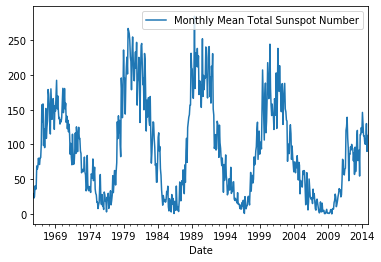

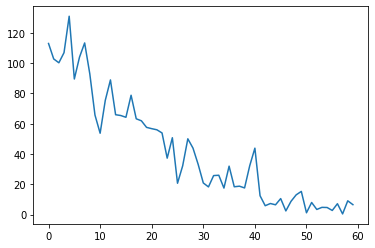

In [11]:
predictions = list()
for t in range(len(forecast)):
    predictions.append(forecast[t])

predictions_new = np.squeeze(predictions)    
test_data = test_data[:len(forecast)]    
error = mean_squared_error(test_data[0: len(predictions_new[0])], predictions_new[0])
print('Test MSE: %.3f' % error)


DataFrame(test_data).plot()
plt.show()

plt.plot(predictions_new[0])
plt.show()

###### Задание 5.
Сравните качество прогноза моделей.
Какой максимальный результат удалось получить на контрольной выборке?


Обе модели достаточно качественно делают прогноз, однако в данном примере модель ARIMA отработала лучше.